In [1]:
# packages

%matplotlib inline

from math import*
import matplotlib.pyplot as plt
import numpy as np
from array import*
import scipy.integrate as integrate
from scipy.interpolate import interp1d
import scipy.optimize as optimization
from scipy.special import erf
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
from array import array
from IPython.display import HTML
from IPython.display import display
from datetime import datetime, timedelta, date
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates

# Radon-222 to Plumbum-210 and Polonium-210 contamination tracker

## Flora Pennartz, June 2021

This program can be used to track down the accumulated amount of Radon-222 daughters Polonium-210 and Plumbum-210 when flushing the XAMSL setup with Radon. 

While fluhsing with Radon, some of the Radon decays into Plumbum. After the flushing, the Radon will be pumped out, but the Plumbum will stay, decaying into Polonium. The decaying Polonium could create noise in the setup.

The program first caculates the amout of Plumbum formed during the flushing, by solving the below formula for Radon and using the time duration of the flushing.

$$N = N_{0}e^{-\lambda t}$$

The number of Plumbum atoms is simpy the start Radon value minus the end Radon value. Then, the script takes the outcome for Plumbum and uses it for the same calculation; this time for Plumbum decaying into Polonium. The relation between activity and number of atoms is  given by the formula below.

$$A = \lambda N = -\frac{dN}{dt} $$

In [2]:
# constants

lambda_Rn222 = 2.1e-6 # decay constant Rn222 in s-1
lambda_Pb210 = 9.9e-10 # decay constant Pb210 in s-1
lambda_Po210 = 25.8e-8 # decay constant Po210 in s-1

DF = 1 # detector efficiency, needs to be determined

In [3]:
# functions

def Rn222_to_Pb210 (start_time_flush, end_time_flush, start_flush_N_Rn222):
      
    start_time_unix = start_time_flush.timestamp()
    end_time_unix = end_time_flush.timestamp()  
    len_time_unix = end_time_unix - start_time_unix
    
    if end_time_flush > start_time_flush:
        end_flush_N_Rn222 = int(start_flush_N_Rn222*np.exp(-lambda_Rn222*len_time_unix))
        end_flush_N_Pb210 = int(start_flush_N_Rn222 - end_flush_N_Rn222)
    
    else:
        end_flush_N_Rn222 = 0
        end_flush_N_Pb210 = 0
          
    return end_flush_N_Rn222, end_flush_N_Pb210    

def Pb210_to_Po210 (start_decay_time, end_decay_time, end_flush_N_Pb210):
      
    start_time_unix = start_decay_time.timestamp()
    end_time_unix = end_decay_time.timestamp()  
    len_time_unix = end_time_unix - start_time_unix
    
    if end_decay_time > start_decay_time:
        end_decay_N_Pb210 = int(end_flush_N_Pb210*np.exp(-lambda_Pb210*len_time_unix))
        end_decay_N_Po210 = int(end_flush_N_Pb210 - end_decay_N_Pb210)
        
    else:
        end_decay_N_Pb210 = 0
        end_decay_N_Po210 = 0
   
    return end_decay_N_Pb210, end_decay_N_Po210

# What day do you want to check?
Say, you want to know the accumulated Polonium after so many Radon flushings on the 1st of January, 2025, midnight.

In [4]:
# format is (yyyy, [m]m, [d]d, [h]h, [m]m, [s]s)
end_decay_time = datetime(2025, 1, 1, 0, 0, 0)

# Radon flush 1
This function determines the amount of Radon and Plumbum after a certain flushing time: you only need to give the flush start time, flush end time and the number of Radon atoms at the start of the flush. I filled in an example.

In [5]:
start_time_flush_1 = datetime(2015, 6, 1, 9, 0, 0) # format dates is (yyyy, m, d, h, m, s))
end_time_flush_1 = datetime(2015, 6, 30, 17, 30, 30)
start_flush_N_Rn222_1 = 50000*DF

end_flush_N_Rn222_1, end_flush_N_Pb210_1 = Rn222_to_Pb210 (start_time_flush_1, end_time_flush_1, start_flush_N_Rn222_1) 

print('With a start N value for Rn222:', start_flush_N_Rn222_1)
print('Number of Radon-222 atoms due to 1st flushing between', start_time_flush_1, 'and', end_time_flush_1,'will be:', end_flush_N_Rn222_1)
print('Number of Plumbum-210 atoms due to 1st flushing between', start_time_flush_1, 'and', end_time_flush_1,'will be:', end_flush_N_Pb210_1)

start_decay_time_1 = end_time_flush_1

end_decay_N_Pb210_1, end_decay_N_Po210_1 = Pb210_to_Po210 (start_decay_time_1, end_decay_time, end_flush_N_Pb210_1)

print('Number of Plumbum-210 atoms due to 1st flush, left alone between', start_decay_time_1, 'and', end_decay_time,'will be:', end_decay_N_Pb210_1)
print('Number of Polonium-210 atoms due to 1st flush, left alone between', start_decay_time_1, 'and', end_decay_time,'will be:', end_decay_N_Po210_1)


With a start N value for Rn222: 50000
Number of Radon-222 atoms due to 1st flushing between 2015-06-01 09:00:00 and 2015-06-30 17:30:30 will be: 243
Number of Plumbum-210 atoms due to 1st flushing between 2015-06-01 09:00:00 and 2015-06-30 17:30:30 will be: 49757
Number of Plumbum-210 atoms due to 1st flush, left alone between 2015-06-30 17:30:30 and 2025-01-01 00:00:00 will be: 36971
Number of Polonium-210 atoms due to 1st flush, left alone between 2015-06-30 17:30:30 and 2025-01-01 00:00:00 will be: 12786


# Radon flush 2
Here, you can add a second flushing. Example dates and times have been given.

In [6]:
# second Radon flushig
start_time_flush_2 = datetime(2022, 7, 1, 9, 0, 0)
end_time_flush_2 = datetime(2022, 7, 30, 17, 30, 30)
start_flush_N_Rn222_2 = 30000*DF

end_flush_N_Rn222_2, end_flush_N_Pb210_2 = Rn222_to_Pb210 (start_time_flush_2, end_time_flush_2, start_flush_N_Rn222_2) 

print('With a start N value for Rn222:', start_flush_N_Rn222_2)
print('Number of Radon-222 atoms due to 2nd flushing between', start_time_flush_2, 'and', end_time_flush_2,'will be:', end_flush_N_Rn222_2)
print('Number of Plumbum-210 atoms due to 2nd flushing between', start_time_flush_2, 'and', end_time_flush_2,'will be:', end_flush_N_Pb210_2)

start_decay_time_2 = end_time_flush_2

end_decay_N_Pb210_2, end_decay_N_Po210_2 = Pb210_to_Po210 (start_decay_time_2, end_decay_time, end_flush_N_Pb210_2) 
print('Number of Plumbum-210 atoms due to 2nd flush, left alone between', start_decay_time_2, 'and', end_decay_time,'will be:', end_decay_N_Pb210_2)
print('Number of Polonium-210 atoms due to 2nd flush, left alone between', start_decay_time_2, 'and', end_decay_time,'will be:', end_decay_N_Po210_2)

With a start N value for Rn222: 30000
Number of Radon-222 atoms due to 2nd flushing between 2022-07-01 09:00:00 and 2022-07-30 17:30:30 will be: 145
Number of Plumbum-210 atoms due to 2nd flushing between 2022-07-01 09:00:00 and 2022-07-30 17:30:30 will be: 29855
Number of Plumbum-210 atoms due to 2nd flush, left alone between 2022-07-30 17:30:30 and 2025-01-01 00:00:00 will be: 27677
Number of Polonium-210 atoms due to 2nd flush, left alone between 2022-07-30 17:30:30 and 2025-01-01 00:00:00 will be: 2178


# Radon flush 3
And a third!

In [7]:
# third Radon flushig

start_time_flush_3 = datetime(2023, 8, 14, 9, 0, 0)
end_time_flush_3 = datetime(2023, 12, 14, 17, 0, 0)
start_flush_N_Rn222_3 = 50000*DF

end_flush_N_Rn222_3, end_flush_N_Pb210_3 = Rn222_to_Pb210 (start_time_flush_3, end_time_flush_3, start_flush_N_Rn222_3) 

print('With a third flush start N value for Rn222:', start_flush_N_Rn222_3)
print('Number of Radon-222 atoms due to 3rd flushing between', start_time_flush_3, 'and', end_time_flush_3,'will be:', end_flush_N_Rn222_3)
print('Number of Plumbum-210 atoms due to 3rd flushing between', start_time_flush_3, 'and', end_time_flush_3,'will be:', end_flush_N_Pb210_3)

start_decay_time_3 = end_time_flush_3

end_decay_N_Pb210_3, end_decay_N_Po210_3 = Pb210_to_Po210 (start_decay_time_3, end_decay_time, end_flush_N_Pb210_3) 
print('Number of Plumbum-210 atoms due to 3rd flush, left alone between', start_decay_time_3, 'and', end_decay_time,'will be:', end_decay_N_Pb210_3)
print('Number of Polonium-210 atoms due to 3rd flush, left alone between', start_decay_time_3, 'and', end_decay_time,'will be:', end_decay_N_Po210_3)

With a third flush start N value for Rn222: 50000
Number of Radon-222 atoms due to 3rd flushing between 2023-08-14 09:00:00 and 2023-12-14 17:00:00 will be: 0
Number of Plumbum-210 atoms due to 3rd flushing between 2023-08-14 09:00:00 and 2023-12-14 17:00:00 will be: 50000
Number of Plumbum-210 atoms due to 3rd flush, left alone between 2023-12-14 17:00:00 and 2025-01-01 00:00:00 will be: 48387
Number of Polonium-210 atoms due to 3rd flush, left alone between 2023-12-14 17:00:00 and 2025-01-01 00:00:00 will be: 1613


# Radon flush 4
You can add another flushing by copying the "Radon flush 3" cell, fill in start_time_flush_3, end_time_flush_3, start_flush_N_Rn222_3, and change all 3's into 4's. Then, add end_decay_N_Pb210_4 and end_decay_N_Po210_4 in the accumulation cells. 

# Accumulation
Here you'll find the accumulation N and A for both Plumbum and Polonium, after all the flushes.

In [8]:
accum_N_Pb210 = end_decay_N_Pb210_1 + end_decay_N_Pb210_2 + end_decay_N_Pb210_3

print('On', end_decay_time, 'the accumulated number of Pb-210 atoms from all flushes since', start_time_flush_1,'will be', accum_N_Pb210)
print('The accompanying activity of Pb-210 will be', lambda_Pb210*accum_N_Pb210, 'Bq')

On 2025-01-01 00:00:00 the accumulated number of Pb-210 atoms from all flushes since 2015-06-01 09:00:00 will be 113035
The accompanying activity of Pb-210 will be 0.00011190465000000001 Bq


In [9]:
accum_N_Po210 = end_decay_N_Po210_1 + end_decay_N_Po210_2 + end_decay_N_Po210_3

print('On', end_decay_time, 'the accumulated number of Po-210 atoms from all flushes since', start_time_flush_1,'will be', accum_N_Po210)
print('The accompanying activity of Po-210 will be', lambda_Po210*accum_N_Po210, 'Bq')

On 2025-01-01 00:00:00 the accumulated number of Po-210 atoms from all flushes since 2015-06-01 09:00:00 will be 16577
The accompanying activity of Po-210 will be 0.004276866 Bq


# Graph
Visual representation of the number of Radon, Plumbum and Polonium atoms. The first cell creates a list of all dates between start_time_flush_1 and end_decay_time. The second cell creates a accumulated Radon, Plumbum and Polonium value for every date. In the third cell, the accumulated values are plotted to time. 

In [10]:
# Begin time = start_time_flush_1
# End time = end_decay_time

alldates_list = []

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

for dt in daterange(start_time_flush_1, end_decay_time):
    alldates_list.append(dt)
    

In [11]:
# the Pb and Po plots: this is done numerically, since the different flushes make a analytic function impossible

accum_N_Pb210_list = []
accum_N_Po210_list = []

for i in alldates_list:
         
    end_decay_N_Pb210_1, end_decay_N_Po210_1 = Pb210_to_Po210 (start_decay_time_1, i, end_flush_N_Pb210_1) 
    end_decay_N_Pb210_2, end_decay_N_Po210_2 = Pb210_to_Po210 (start_decay_time_2, i, end_flush_N_Pb210_2) 
    end_decay_N_Pb210_3, end_decay_N_Po210_3 = Pb210_to_Po210 (start_decay_time_3, i, end_flush_N_Pb210_3) 
    # to add a fourth, copy above line and replace 3 by 4
    
    accum_N_Pb210 = end_decay_N_Pb210_1 + end_decay_N_Pb210_2 + end_decay_N_Pb210_3 # and add + end_decay_N_Pb210_4 and 
    accum_N_Po210 = end_decay_N_Po210_1 + end_decay_N_Po210_2 + end_decay_N_Po210_3 # and + end_decay_N_Po210_4
     
    accum_N_Pb210_list.append(accum_N_Pb210)
    accum_N_Po210_list.append(accum_N_Po210)

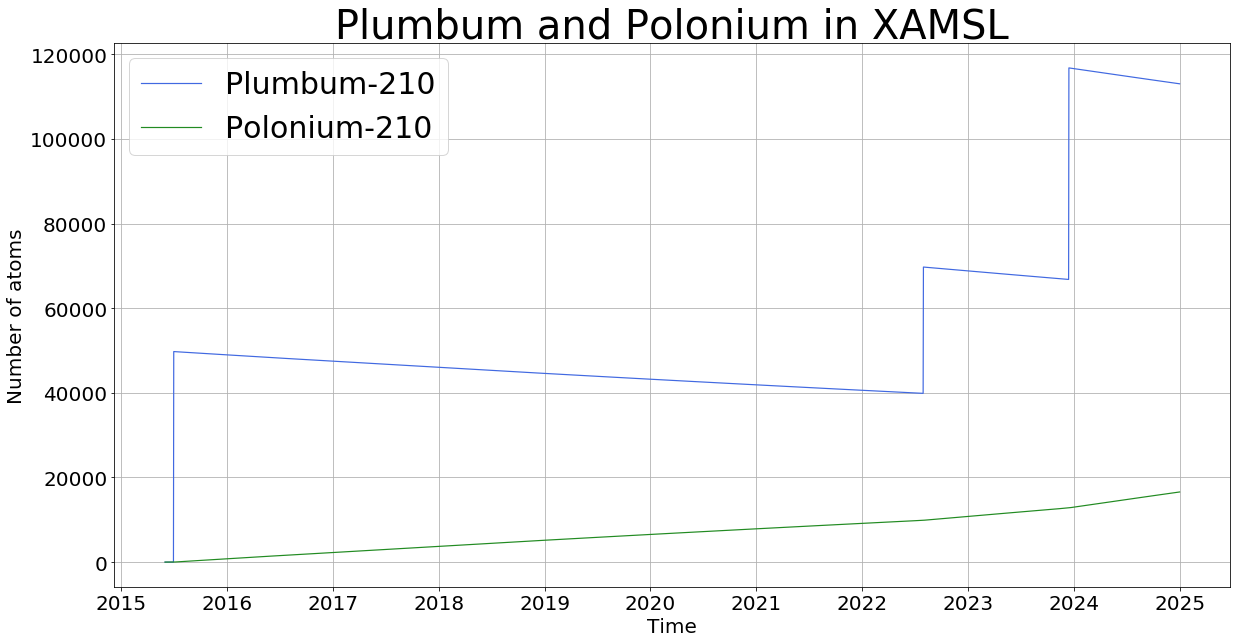

In [12]:
# plot it!

fig = plt.figure(figsize=(20,10))

plt.subplot(1, 1, 1)
p2 = plt.plot(alldates_list, accum_N_Pb210_list,'royalblue',linewidth = 1.2,label = 'Plumbum-210')
p3 = plt.plot(alldates_list, accum_N_Po210_list,'forestgreen',linewidth = 1.2,label = 'Polonium-210')
plt.title('Plumbum and Polonium in XAMSL', fontsize=40)
#plt.yscale('log')
plt.legend(prop={'size': 30})
plt.ylabel('Number of atoms',fontsize=20)
plt.xlabel('Time',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()